# Gaussian Process Example 1 #

The GP model is widely considered at the reference when doing ensemble modeling. This notebook can serve to test the behaviour of GP within the context of scikit learn. In theory, 1 GP should be "an ensemble" in it's own right...so comparison should be made to single GP instances. Basic information on how to use GP in sklearn can be found here: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [1]:
#Some imports
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import scipy.stats as st
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, KFold

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel as C

In [61]:
#Generating the synthetic data
Nmodels=100
Ndims=5
Ndata=50
Nrem=int(Ndata*0.2)
r=np.random.uniform(low=-4,high=4,size=(Ndims,Ndata)).T # N-D euclidian position-vector
x=np.array([np.sqrt(np.sum(r*r,axis=1))]).T # get the euclidian "radial distance" as positive scalar
y=np.sinc(x).ravel()  #create the associated targets, needs to be a 1D array
#y=np.sin(x).ravel()  #create the associated targets, needs to be a 1D array
y=y+(x*x*0.1).ravel()
x2=x*x
print("mean x²=",np.mean(x2))
print("R=",r.shape,"\nX=",x.shape)

mean x²= 25.995554503711283
R= (50, 5) 
X= (50, 1)


In [65]:
#create Nmodels (identical) rbf-models to train on different datasets
models=list()
datasets_r=list()
datasets_y=list()
for i in range(Nmodels):
    Kernel=None
    #Kernel=1.0 * RBF(length_scale=1, length_scale_bounds=(1e-1, 10.0))
    #Kernel= 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),nu=1.5)
    #Kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
    #Kernel= 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,length_scale_bounds=(0.1, 10.0),periodicity_bounds=(1.0, 10.0))
    clfrbf=GaussianProcessRegressor(
        kernel=Kernel,
    #    alpha=3.0e0,
            )
    #index=list(range(i,i+Nrem))
    index=random.sample(range(Ndata),Nrem)
    seti_r=np.array(np.delete(r,index,axis=0)) #remove selected vector rows
    #print(seti_r.shape,seti_r)
    #print(seti_r.shape," ",seti_r[0:5,:].ravel())
    seti_y=np.delete(y,index)
    clfrbf.fit(seti_r,seti_y) # train our model instance, aka solve the set of linear equations
    datasets_r.append(seti_r)
    datasets_y.append(seti_y)
    models.append(clfrbf)
    print(i,",",end=" ")

0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

In [66]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    cf=(1.0-confidence)*0.5
    qm = np.quantile(a,cf,interpolation='linear')
    qp = np.quantile(a,1.0-cf,interpolation='linear')
    return m, m-h, m+h, qm, qp

Average scores -- MAE=  167.0534971109998  R²=  -6.303485575774446


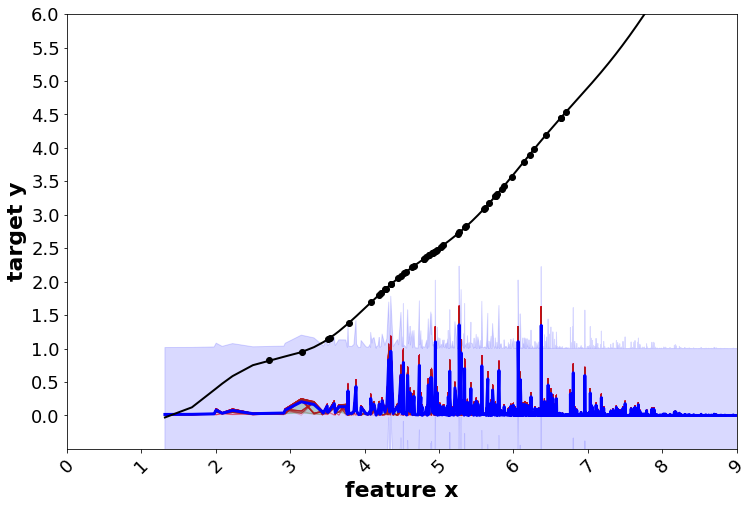

In [67]:
#generate a dens mesh
xmin=0
xmax=8.5
Npts=10000  # number of points, randomly selected in the Ndims dimensional space. (To prevent things from accidentaly exploding)
if Ndims==1:
    #generate Ndim grid
    rPred=np.linspace((xmin,),(xmax,),Npts)
elif Ndims==2:
    #2D sperical grid with uniform random distribution in sphere 
    rPred=np.zeros((2,Npts)).T
    for i in range(1,Npts):
        L=2*xmax
        while L>xmax: #repeat until in circle
            xy=np.random.uniform(low=0,high=xmax,size=2)
            L=np.sqrt(np.sum(xy*xy))
        rPred[i,0:2]=xy[0:2]    
elif Ndims==3:
    #3D sperical grid with uniform random distribution in sphere 
    rPred=np.zeros((3,Npts)).T
    for i in range(1,Npts):
        L=2*xmax
        while L>xmax: #repeat until in sphere
            xyz=np.random.uniform(low=0,high=xmax,size=3)
            L=np.sqrt(np.sum(xyz**2))
        rPred[i,0:3]=xyz[0:3]
else :
    rPred=np.random.uniform(low=0,high=xmax,size=(Ndims,Npts)).T # N-D euclidian position-vector
    
xPred=np.array([np.sqrt(np.sum(rPred*rPred,axis=1))]).T # get the euclidian "radial distance" as positive scalar

#The randomness of the x's gives some issues for plotting purposes, so sort everything wrt the radial value x
indexSort=np.argsort(xPred,axis=0).ravel()
xPred=np.sort(xPred,axis=0)
rPred=rPred[indexSort[::1]]

yExact=np.sinc(xPred).ravel()
#yExact=np.sin(xPred).ravel()
yExact=yExact+(xPred*xPred*0.1).ravel()

yAvg=np.zeros(Npts)
CIlow=np.zeros(Npts)
CIhigh=np.zeros(Npts)
Qlow=np.zeros(Npts)
Qhigh=np.zeros(Npts)
# and predict
all_yPred=list()
yPred2D=np.zeros((Nmodels,Npts))
sigmaPred2D=np.zeros((Nmodels,Npts))
cnt=-1

ERRORS=np.zeros((Nmodels,2))
for clfrbf in  models:
    cnt+=1
    yPred, sigma=clfrbf.predict(rPred,return_std=True)
    #print(cnt," : sigma=",sigma)
    all_yPred.append(yPred)
    yPred2D[cnt]=yPred
    sigmaPred2D[cnt]=sigma
    # The mean squared error (MAE) and The coefficient of determination R²: 1 is perfect prediction
    ERRORS[cnt,0]=mean_squared_error(yExact, yPred)
    ERRORS[cnt,1]=r2_score(yExact, yPred)
    #print('MAE: %.3f    R²: %.3f' % (mean_squared_error(yExact, yPred), r2_score(yExact, yPred)))

print("Average scores -- MAE= ",np.mean(ERRORS[:,0])," R²= ",np.mean(ERRORS[:,1]))
    
for i in range(Npts):
    yAvg[i], CIlow[i], CIhigh[i], Qlow[i], Qhigh[i]= mean_confidence_interval(yPred2D[:,i],confidence=0.9)
    CIlow[i]=yAvg[i]-np.mean(sigmaPred2D[:,i])
    CIhigh[i]=yAvg[i]+np.mean(sigmaPred2D[:,i])
    #print(yExact[i],"=?=",yAvg[i], CIlow[i], CIhigh[i],"--> ",yPred2D[1:5,i])
    
# Plot outputs
plt.figure(figsize=(12,8))
for yPred in all_yPred:
    plt.plot(xPred, yPred,   color='red'  ,linewidth=1, zorder=-1, alpha=0.25)
    #plt.scatter(xPred, yPred,   color='red' ,s=1 , zorder=-1, alpha=0.25)


plt.fill_between(xPred.ravel(), CIlow, CIhigh, color='blue', zorder=0, alpha=.15)
plt.fill_between(xPred.ravel(), Qlow, Qhigh, color='green', zorder=0, alpha=.2)
plt.plot(xPred, yAvg,  color='blue',linewidth=3, zorder=0)

plt.plot(xPred, yExact,  color='black',linewidth=2, zorder=0)
plt.scatter(x, y,  color='black', zorder=1)

plt.axis([xmin,xmax,-.5,6])
step=(xmax-xmin)/11.0
Xlst=list()
for a in np.arange(math.floor(xmin),math.ceil(xmax)+1,1.0):
    Xlst.append(a)
plt.xticks(Xlst,rotation=45,fontsize=18)
#plt.xticks([-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
plt.yticks([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6],fontsize=18)
plt.xlabel("feature x",fontsize=22,fontweight="bold")
plt.ylabel("target y",fontsize=22,fontweight="bold")

plt.show()